In [1]:
# Numpy and Pandas
import numpy as np
import pandas as pd
from numpy import mean
from numpy import std
import time
# Iterative Stratification untuk cross validation multilabel
from skmultilearn.model_selection import IterativeStratification

#Import Tensorflow dan extension
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import Dense
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, Activation
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.callbacks import  EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.backend import sigmoid
from tensorflow.keras.optimizers import Adam, Nadam, Adagrad, SGD, RMSprop, Adadelta

#Import keras tuner dan metrics untuk tuning parameter
import kerastuner as kt
from kerastuner.tuners import RandomSearch, BayesianOptimization, Sklearn
from sklearn import metrics
import tensorflow_addons as tfa

D:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:25: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [2]:
#Modifikasi IterativeStratification agar hasil random data tetap sama

def new_init(self, n_splits=3, order=1, sample_distribution_per_fold = None, random_state=None):

                  self.order = order
                  if random_state is not None:
                      do_shuffle = True
                  else:
                      do_shuffle = False
                  super(
                      IterativeStratification,
                      self).__init__(n_splits,
                                     shuffle=do_shuffle,
                                     random_state=random_state)
                  if sample_distribution_per_fold:
                      self.percentage_per_fold = sample_distribution_per_fold
                  else:
                      self.percentage_per_fold = [1 / float(self.n_splits) for _ in range(self.n_splits)]
    
IterativeStratification.__init__ = new_init
# cv = IterativeStratification(n_splits=5, random_state = 123)

In [4]:
# Cek aktif CUDA
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())
print(tf.test.is_built_with_cuda())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15983452752511091759
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 6104315771675428329
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4975434144
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5279947906580774944
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 3088785927928456411
physical_device_desc: "device: XLA_GPU device"
]
True


In [5]:
#Import Dataset
dataset_pubchem = pd.read_csv('D:\Thesis\Data\com_fp_pubchem.csv')
kelasdata = pd.read_csv('D:\Thesis\Data\kelasdataNew.csv')
X = dataset_pubchem
Y = np.array(kelasdata)

# SAE MODEL

In [7]:
#Fungsi model SAE
def sae_model(xt, xv = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5,
              verbose = 0,return_fe = False):
  #Setting result placeholders
  xt_ae = [] ;xv_ae = [] ; w_ae = []
  #If validation set is not present, use train set as validation set
  if xv is None :
    xv = xt.copy()
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate

  #Stacked Autoencoder architecture
  for n_layers in range(num_layers):
    #Autoencoder
    inp = Input(shape=(xt.shape[1],))
    #Apply Dropout
    hidden_layer = Dropout(do)(inp)
    #Layer encoder (jumlah layer sesuai dengan n_layers)
    enc = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)  
    #Layer Decoder
    dec = Dense(xt.shape[1],activation="linear")(enc)
    ae = Model(inp, dec)
    #Compile model
    ae.compile(optimizer=opt, loss='mean_squared_error')
    #EarlyStop jika sudah konvergen 
    es = EarlyStopping(monitor='val_loss', patience=15, verbose=verbose)
    #Latih model
    ae.fit(xt, xt, 
           epochs=EPOCHS,batch_size=BATCH_SIZE, 
           shuffle=True, callbacks = [es] , verbose = verbose,
           validation_data = (xv,xv))
    #Ekstrak Feature extraction
    fe = Model(ae.input, enc)
    #Simpan data hasil latih
    xt = fe.predict(xt) ; xt_ae.append(xt)
    xv = fe.predict(xv) ; xv_ae.append(xv)
    #Simpan bobot hasil latih SAE
    w_ae.append([layer_name for layer_name in ae.layers if "dense" in layer_name.name][0].get_weights())
    if verbose:
      print("Layer {} trained".format(n_layers+1))

  return (w_ae,xv) if return_fe else w_ae

# BUILD DNN

In [8]:
#Fungsi DNN
def dnn_model(xt, n_outputs = 473, sae_weights = None, EPOCHS = 100,BATCH_SIZE = 32, opt = "adam",
              hl_node = 1024, lr = 0.01,af = "relu",num_layers = 3, do=0.5, fr_node = 0.5):
  opt = tf.keras.optimizers.get(opt) #Set optimizer
  K.set_value(opt.learning_rate, lr) #Set learning rate
  
  #Model architecture
  input_layer = Input(shape=(xt.shape[1],))
  hidden_layer = BatchNormalization()(input_layer)
  hidden_layer = Dropout(do)(hidden_layer)
#Set jumlah hidden layer
  for n_layers in range(num_layers):
    hidden_layer = Dense(int(hl_node*(fr_node**n_layers)), activation = af)(hidden_layer)
    hidden_layer = BatchNormalization()(hidden_layer)
    hidden_layer = Dropout(do)(hidden_layer)
  output_layer = Dense(n_outputs, activation = 'sigmoid')(hidden_layer)
#latih model
  dnn = Model(input_layer, output_layer)

  #Latih model DNN dengan bobot SAE (jika bobot ada)
  if sae_weights is not None:
    weights = sae_weights
    dnn_dense = [layer_name for layer_name in dnn.layers if "dense" in layer_name.name]
    for weight_from,weight_to in list(zip(weights,dnn_dense)):
      weight_to.set_weights(weight_from)

  #Compile model
  dnn.compile(optimizer=opt, loss='binary_crossentropy', metrics = [tf.keras.metrics.BinaryAccuracy(),
               tf.keras.metrics.Precision(),
               tf.keras.metrics.Recall()],
               )
  return dnn

In [21]:

np.random.seed(123)
cv = IterativeStratification(n_splits=5, random_state = 123)

In [10]:
#Train SAE-DNN
#Variabel untuk simpan hasil
acc_results = list()
f1_results = list()
prec_results = list()
rec_results = list()
# define evaluation procedure
np.random.seed(123)
#Inisialisasi CV
cv = IterativeStratification(n_splits=5, random_state = 123)
#Latih SAE 
print("finding sae weights....")
ti0 = time.time()
sae_weights = sae_model(xt = X)
ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
#Mulai latih DNN dengan bobot hasil SAE untuk tiap CV
for train_ix, test_ix in cv.split(X,Y):
    #Bagi data menjadi train, test
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model dengan bobot SAE. Jika tidak memakai bobot SAE, sae_weights = None
    model = dnn_model(xt = X_train, sae_weights = sae_weights)
    # latih model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # Prediksi test 
    yhat = model.predict(X_test)
    # Bulatkan hasil prediksi (probabilitas)
    yhat = yhat.round()
    # Hitung metrik
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # Simpan hasil
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
t1 = time.time()
print("waktu proses", t1-t0)
print("Accuracy array:", acc_results)
print("F1 array:", f1_results)
print("Precision array:", prec_results)
print("Recall array:", rec_results)
#save model
model.save("sae_dnn_awal.h5")
        

finding sae weights....
done, processing time: 177.56379961967468


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.785
F1 of :>0.831
Precision of :>0.838
Recall of :>0.837


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  1
accuracy of :>0.779
F1 of :>0.828
Precision of :>0.836
Recall of :>0.835


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  2
accuracy of :>0.789
F1 of :>0.839
Precision of :>0.845
Recall of :>0.850


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  3
accuracy of :>0.791
F1 of :>0.833
Precision of :>0.841
Recall of :>0.839


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  4
accuracy of :>0.771
F1 of :>0.812
Precision of :>0.822
Recall of :>0.815
waktu proses 1631.430603981018
Accuracy array: [0.7847542627883651, 0.7791817087845969, 0.7890971382507054, 0.7906813627254509, 0.7713658146964856]
F1 array: [0.8309617694364005, 0.8281768942985054, 0.8394727932815119, 0.8332489705762782, 0.8122377384774684]
Precision array: [0.8379341728890376, 0.8360927263003075, 0.8445843969725468, 0.8406563126252505, 0.8220929845580405]
Recall array: [0.8373189228580403, 0.8347220457446481, 0.8501099467927351, 0.8386456773150749, 0.814587920468071]


In [11]:
#Train DNN saja
acc_results2 = list()
f1_results2 = list()
prec_results2 = list()
rec_results2 = list()
n_inputs, n_outputs = X.shape[1], 473
# define evaluation procedure
# cv = IterativeStratification(n_splits=5, random_state = 123)
i=0
# enumerate folds
t0 = time.time()
for train_ix, test_ix in cv.split(X,Y):
    # prepare data
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model tanpa bobot SAE
    model = dnn_model(xt = X_train, sae_weights = None)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results2.append(acc)
    f1_results2.append(f1)
    prec_results2.append(prec)
    rec_results2.append(rec)
t1 = time.time()
print("waktu proses", t1-t0)
print("Accuracy array:", acc_results2)
print("F1 array:", f1_results2)
print("Precision array:", prec_results2)
print("Recall array:", rec_results2)
#save model
model.save("dnn_only_NewData40k.h5")
        

D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.764
F1 of :>0.796
Precision of :>0.808
Recall of :>0.794


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.785
F1 of :>0.835
Precision of :>0.839
Recall of :>0.846


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.787
F1 of :>0.840
Precision of :>0.845
Recall of :>0.850


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.782
F1 of :>0.830
Precision of :>0.837
Recall of :>0.837


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.786
F1 of :>0.836
Precision of :>0.841
Recall of :>0.844
waktu proses 1480.8042051792145
Accuracy array: [0.763541874875075, 0.7853629153699427, 0.7867816668338181, 0.7822978552008861, 0.7863504453117182]
F1 array: [0.7959544722771771, 0.8349899918006455, 0.839655229558663, 0.8302230173433441, 0.8356430372547815]
Precision array: [0.8077013441058173, 0.8392129304286717, 0.8450824056430314, 0.8370959621387575, 0.841402314953801]
Recall array: [0.7941990308542282, 0.8455799642414942, 0.8496960940994227, 0.8374929836942727, 0.844372265704404]


In [12]:
print('===================================')
print('SAE-DNN PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results), np.std(acc_results)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results), np.std(f1_results)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results), np.std(prec_results)))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(rec_results), np.std(rec_results)))
print('===================================')
print('===================================')
print('DNN ONLY PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results2), np.std(acc_results2)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results2), np.std(f1_results2)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results2), np.std(prec_results2)))
print('Recall       : {0:.5f}±{1:.3f}'.format(np.mean(rec_results2), np.std(rec_results2)))
print('===================================')

SAE-DNN PERFORMANCE
Accuracy    : 0.78302±0.007
F1 Score    : 0.82882±0.009
Precision   : 0.83627±0.008
Recall      : 0.83508±0.012
DNN ONLY PERFORMANCE
Accuracy    : 0.78087±0.009
F1 Score    : 0.82729±0.016
Precision   : 0.83410±0.013
Recall       : 0.83427±0.020


# TUNING PARAM

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size = 0.2)

In [12]:
#Fungsi model untuk tuning
def build_model(hp):
    #Isi parameter yang akan dituning
    params = {
              'hl_node' : hp.Choice('units',values = [1500,1600,1700,1800]),
              'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
              'opt' : hp.Choice('optimizer',values=["adam", "adagrad"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[0.5,0.6,0.7,0.8]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    #Latih model SAE
    sae_weights = sae_model(xt = X, xv = X_train, EPOCHS= 100,**params)
    #Latih model DNN dengan bobot SAE
    sae_dnn = dnn_model(X_train, sae_weights=sae_weights, EPOCHS= 100,**params)
    return sae_dnn

In [14]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall',patience = 25)
# Fungsi Bayesian Optimization di Keras Tuner.
tuner = BayesianOptimization(build_model,
    # Metrik yang dicari optimalnya
    objective= kt.Objective("val_recall", direction="max"), 
    # Jumlah percobaan
    max_trials=20,
    executions_per_trial=2,
    # Folder simpan hasil tuning
    directory='D:\Thesis\Tuning Folder',
    project_name='sae_dnn_tuning_bayesFiltered40k', overwrite = True)
#Jalankan Keras Tuner u
tuner.search(X_train, y_train, epochs=100, validation_data=(X_test, y_test),callbacks=[stop_early])
#Tampilkan hasil terbaik
tuner.results_summary()

Trial 20 Complete [00h 08m 04s]
val_recall: 0.7977643013000488

Best val_recall So Far: 0.8132519721984863
Total elapsed time: 03h 13m 24s
INFO:tensorflow:Oracle triggered exit


In [15]:
#Archived
tuner.results_summary()

Results summary
Results in D:\Thesis\Tuning Folder\sae_dnn_tuning_bayesFiltered40k
Showing 10 best trials
Objective(name='val_recall', direction='max')
Trial summary
Hyperparameters:
units: 1500
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.8132519721984863
Trial summary
Hyperparameters:
units: 1600
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.800110936164856
Trial summary
Hyperparameters:
units: 1500
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.7977643013000488
Trial summary
Hyperparameters:
units: 1500
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.7947350442409515
Trial summary
Hyperparameters:
units: 1500
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.7920897901058197
Trial summary
Hyperparameters:
units: 1800
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.7917911112308502
Trial summary
Hyperpar

In [23]:
#Train SAE-DNN with BEST HP 
acc_results_tuned = list()
f1_results_tuned = list()
prec_results_tuned = list()
rec_results_tuned = list()
n_inputs, n_outputs = X.shape[1], 473
# define evaluation procedure

print("finding sae weights....")
ti0 = time.time()

sae_weigths_tuned = sae_model(xt = X, hl_node = 1500, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)

ti1 = time.time()
print('done, processing time:', ti1-ti0)
i=0
t0 = time.time()
# enumerate folds
np.random.seed(123)
for train_ix, test_ix in cv.split(X,Y):
    # prepare data
    X_train, X_test = X.iloc[train_ix,:], X.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model
    model_tuned = dnn_model(xt = X_train, sae_weights = sae_weigths_tuned, hl_node = 1500, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
    # fit model
    model_tuned.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model_tuned.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results_tuned.append(acc)
    f1_results_tuned.append(f1)
    prec_results_tuned.append(prec)
    rec_results_tuned.append(rec)
    i=i+1
t1 = time.time()
print("waktu proses: ", t1-t0)
print("Accuracy array:", acc_results_tuned)
print("F1 array:", f1_results_tuned)
print("Precision array:", prec_results_tuned)
print("Recall array:", rec_results_tuned)
#save model
model_tuned.save("sae_dnn_tuned_lastrunNew40k.h5")

finding sae weights....
done, processing time: 228.55288553237915


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.783
F1 of :>0.849
Precision of :>0.847
Recall of :>0.869


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  1
accuracy of :>0.791
F1 of :>0.846
Precision of :>0.848
Recall of :>0.859


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  2
accuracy of :>0.782
F1 of :>0.842
Precision of :>0.843
Recall of :>0.859


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  3
accuracy of :>0.795
F1 of :>0.850
Precision of :>0.850
Recall of :>0.865


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  4
accuracy of :>0.787
F1 of :>0.843
Precision of :>0.843
Recall of :>0.857
waktu proses:  1747.2818326950073
Accuracy array: [0.7825476429287863, 0.7909145607701564, 0.7818419991938734, 0.7947895791583166, 0.7872404153354633]
F1 array: [0.8486562643347364, 0.8458321154383659, 0.8418763779016534, 0.8496765366562451, 0.84255572180681]
Precision array: [0.8472749328015127, 0.8482209711000326, 0.8427170821304473, 0.8503510452277102, 0.8434670922627692]
Recall array: [0.8686253421158137, 0.8593086668457489, 0.8588248245523529, 0.8646714486183128, 0.857482730648533]


In [24]:
# print('===================================')
# print('SAE-DNN PERFORMANCE')
# print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results), np.std(acc_results)))
# print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(f1_results), np.std(f1_results)))
# print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results), np.std(prec_results)))
# print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(rec_results), np.std(rec_results)))
# print('===================================')
print('===================================')
print('===================================')
print('SAE-DNN TUNED PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results_tuned), np.std(acc_results_tuned)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results_tuned), np.std(f1_results_tuned)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results_tuned), np.std(prec_results_tuned)))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(rec_results_tuned), np.std(rec_results_tuned)))
print('===================================')
print('===================================')


SAE-DNN TUNED PERFORMANCE
Accuracy    : 0.78747±0.005
F1 Score    : 0.84572±0.003
Precision   : 0.84641±0.003
Recall      : 0.86178±0.004


In [3]:
from tensorflow.keras.models import load_model
sae_dnn_model_pubchem = load_model('sae_dnn_tuned_lastrunNew40k.h5')
# summarize model.
sae_dnn_model_pubchem.summary()

Model: "functional_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        [(None, 881)]             0         
_________________________________________________________________
batch_normalization_15 (Batc (None, 881)               3524      
_________________________________________________________________
dropout_19 (Dropout)         (None, 881)               0         
_________________________________________________________________
dense_23 (Dense)             (None, 1500)              1323000   
_________________________________________________________________
batch_normalization_16 (Batc (None, 1500)              6000      
_________________________________________________________________
dropout_20 (Dropout)         (None, 1500)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 750)             

In [4]:
data_herbal2 = pd.read_excel('D:/Jupyter/ujimbafikanorm.xlsx',header= None).drop_duplicates()
data_herbal2 = data_herbal2.iloc[:,0:882]
data_herbal2 = data_herbal2.drop_duplicates()
data_herbal2

,0,1,2,3,4,5,6,7,8,9,...,872,873,874,875,876,877,878,879,880,881
0,Syringaresinol,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,Amaranthine,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,Methylthio,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,arabinopyrano,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
32,Peonidin-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
40,Quercetin-3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
48,Theviridoside,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
56,Sinigrin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64,Caffeoylbeta,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
72,Azadirachtin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
#Hilangkan duplikat
data_herbal1 = pd.read_csv('D:/Jupyter/fpujimbaLinda.csv', header = None).drop_duplicates()
#Sesuaikan dengan data latih
data_herbal1.columns = ["Senyawa"] + list(range(1,882))
data_herbal2.columns = ["Senyawa"] + list(range(1,882))
data_herbal = data_herbal1.append(data_herbal2).drop_duplicates(subset = ["Senyawa"]) 
data_herbal.index = pd.RangeIndex(len(data_herbal.index))
data_herbal.index = range(len(data_herbal.index))
#Drop nama senyawa
data_herbal_test = data_herbal.drop('Senyawa', axis=1)
data_herbal_test

,1,2,3,4,5,6,7,8,9,10,...,872,873,874,875,876,877,878,879,880,881
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
399,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
400,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
401,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [6]:
#Predict data herbal
yhat_herbal_proba =  sae_dnn_model_pubchem.predict(data_herbal_test)
# Bulatkan probabilitas 
yhat_herbal = yhat_herbal_proba.round()
yhat_herbal

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [7]:
yhat_herbal_proba

array([[1.7445452e-26, 4.4854744e-20, 9.7405431e-18, ..., 8.3722973e-21,
        1.2386194e-14, 4.0145177e-19],
       [1.0656728e-30, 1.7308396e-23, 2.1472248e-21, ..., 2.4543294e-23,
        1.0514789e-15, 4.7358345e-20],
       [5.9944594e-24, 7.9863828e-26, 7.9043263e-21, ..., 2.9164153e-21,
        5.4157145e-14, 5.8126875e-17],
       ...,
       [1.2160046e-05, 2.8547942e-07, 3.4293484e-07, ..., 3.9232414e-06,
        7.2495772e-07, 5.3933825e-08],
       [1.7979284e-16, 1.8901373e-16, 4.3576294e-14, ..., 2.8336710e-14,
        9.2190117e-11, 1.0202472e-10],
       [3.0492834e-22, 2.7158274e-21, 2.9781869e-18, ..., 2.4972759e-20,
        2.3107423e-14, 9.2778645e-21]], dtype=float32)

In [12]:
hasil_predict_proba = pd.DataFrame(yhat_herbal_proba, columns = kelasdata.columns)
hasil_predict = pd.DataFrame(yhat_herbal, columns = kelasdata.columns)

In [15]:
# Isi kembali nama senyawa 
hasil_predict['Senyawa']=data_herbal['Senyawa']
hasil_1 = pd.DataFrame(columns = ['Senyawa', 'List Protein', 'Probability'])
# Cari nama protein yang sesuai dengan hasil prediksi
for i in range(len(hasil_predict)):
    #Array protein
    protein_list = []
    #Array Probabilitas
    proba_list = []
    for j in range(0,473):
        #apabila hasil prediksi senyawa bernilai 1 
        if hasil_predict.iloc[i,j]==1:
            #Cari nama senyawa yang sesuai
            hasil_1.loc[i,'Senyawa'] = hasil_predict['Senyawa'][i]
            #Cari nama protein yang sesuai
            protein_name = hasil_predict.columns[j]
            proba = hasil_predict_proba.iloc[i,j]
            #Simpan nama protein dan probabilitasnya
            protein_list.append(protein_name)
            proba_list.append(proba)
    #apabila hasil prediksi bernilai 0, maka Protein None
    if len(protein_list)==0:
        hasil_1.loc[i,'List Protein'] = None
    else:
        hasil_1.loc[i,'List Protein'] = protein_list
    hasil_1.loc[i,'Probability'] = proba_list
#Hapus missing values
hasil_1 = hasil_1.dropna()
#Hitung total protein yang berinteraksi
hasil_1['Total'] = hasil_predict.sum(axis=1)[hasil_predict.sum(axis=1)>=1]
#Urutkan berdasarkan banyak protein
hasil_1.sort_values(by=['Total'], inplace=True)
# Simpan ke file
hasil_1.to_csv('D:/Thesis/Data/HasilPredictSenyawaHerbal2NewFiltered40kBACKUP.csv')

D:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:22: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


In [22]:
# dataset_maccs = pd.read_csv('D:/Thesis/Data/com_fp_maccs.csv')
dataset_circular = pd.read_csv('D:/Thesis/Data/com_fp_circular.csv')
# dataset_daylight = pd.read_csv('D:/Thesis/Data/com_fp_daylightNew.csv')
# X_daylight = dataset_daylight.astype('int64')
# X_maccs = dataset_maccs
X_circular = dataset_circular

# for train_ix, test_ix in cv.split(X_maccs,Y):
    # prepare data
#     print(train_ix.shape,test_ix)
#     X_train2, X_test2 = X_maccs.iloc[train_ix,:], X_maccs.iloc[test_ix,:]
#     y_train2, y_test2 = Y[train_ix], Y[test_ix]
for train_ix, test_ix in cv.split(X_circular, Y):
    X_train3, X_test3 = X_circular.iloc[train_ix,:], X_circular.iloc[test_ix,:]
    y_train3, y_test3 = Y[train_ix], Y[test_ix]
# for train_ix, test_ix in cv.split(X_daylight, Y):
#     X_train4, X_test4 = X_daylight.iloc[train_ix,:], X_daylight.iloc[test_ix,:]
#     y_train4, y_test4 = Y[train_ix], Y[test_ix]

# MACCS

In [23]:
def build_model(hp):
    params = {
              'hl_node' : hp.Choice('units',values = [166,400,500,600,700,800,900,1000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
              'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
#               # 'BATCH_SIZE' : hp.Choice('batch_size',values=[8,16,32]),
              'opt' : hp.Choice('optimizer',values=["adam", "adagrad"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[0.5,0.6,0.7,0.8]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    sae_weights = sae_model(X_maccs, EPOCHS= 100,**params)
    sae_dnn = dnn_model(X_train2, sae_weights=sae_weights, n_outputs=473, EPOCHS= 100,**params)
    return sae_dnn

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=25)
tunermaccs = BayesianOptimization(build_model,
    objective= kt.Objective("val_recall", direction="max"), 
    max_trials=20,
    executions_per_trial=1,
    directory='D:\Thesis\Tuning Folder',
    project_name='sae_dnn_maccs_tuningFiltered5', overwrite = True)
tunermaccs.search(X_train2, y_train2, validation_data=(X_test2,y_test2), epochs=100,callbacks=[stop_early])

Trial 20 Complete [00h 04m 11s]
val_recall: 0.6650931239128113

Best val_recall So Far: 0.6980516910552979
Total elapsed time: 02h 07m 51s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [25]:
#Archived
tunermaccs.results_summary()

Results summary
Results in D:\Thesis\Tuning Folder\sae_dnn_maccs_tuningFiltered5
Showing 10 best trials
Objective(name='val_recall', direction='max')
Trial summary
Hyperparameters:
units: 600
learning_rate: 0.01
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.6980516910552979
Trial summary
Hyperparameters:
units: 1000
learning_rate: 0.01
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.6793408393859863
Trial summary
Hyperparameters:
units: 1000
learning_rate: 0.01
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.6767659187316895
Trial summary
Hyperparameters:
units: 1000
learning_rate: 0.01
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.6717020273208618
Trial summary
Hyperparameters:
units: 1000
learning_rate: 0.01
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.6650931239128113
Trial summary
Hyperparameters:
units: 1000
learning_rate: 0.01
opt

In [27]:
#Train SAE-DNN
acc_results = list()
f1_results = list()
prec_results = list()
rec_results = list()
n_inputs, n_outputs = X.shape[1], 473
print("finding sae weights....")
ti0 = time.time()
sae_weights_maccs = sae_model(xt = X_maccs, hl_node = 600, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.75 ) 
ti1 = time.time()
print('done, processing time:', ti1-ti0)
# define evaluation procedure
# cv = RepeatedKFold(n_splits=5, n_repeats = 1, random_state=1)
i=0
# enumerate folds
t0 = time.time()
for train_ix, test_ix in cv.split(X_maccs, Y):
    t0 = time.time()
    # prepare data
    X_train, X_test = X_maccs.iloc[train_ix,:], X_maccs.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model
    model = dnn_model(xt = X_train, sae_weights = sae_weights_maccs, hl_node = 600, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.75)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
t1 = time.time()
print("waktu proses", t1-t0)    
print("Accuracy array:", acc_results)
print("F1 array:", f1_results)
print("Precision array:", prec_results)
print("Recall array:", rec_results)
#save model
model.save("sae_dnn_maccs40k.h5")


finding sae weights....
done, processing time: 142.55067801475525


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.644
F1 of :>0.690
Precision of :>0.698
Recall of :>0.695


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  1
accuracy of :>0.628
F1 of :>0.672
Precision of :>0.679
Recall of :>0.678


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  2
accuracy of :>0.634
F1 of :>0.678
Precision of :>0.685
Recall of :>0.682


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  3
accuracy of :>0.633
F1 of :>0.673
Precision of :>0.680
Recall of :>0.677


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  4
accuracy of :>0.580
F1 of :>0.614
Precision of :>0.623
Recall of :>0.615
waktu proses 547.8501822948456
Accuracy array: [0.6435822695748317, 0.6275299567012386, 0.6338126622728181, 0.6332228582906498, 0.5803616022375387]
F1 array: [0.6900205263730727, 0.671875836959769, 0.6776164392683618, 0.6726470294439867, 0.6138825184665936]
Precision array: [0.6980433544409824, 0.6794129493505184, 0.6852839358231808, 0.6802698974009294, 0.623041321213332]
Recall array: [0.695424030692783, 0.6778394366145437, 0.6824435472877654, 0.6767467512263518, 0.615166083096727]


In [28]:
print('===================================')
print('SAE-DNN PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results), np.std(acc_results)))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(rec_results), np.std(rec_results)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results), np.std(prec_results)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results), np.std(f1_results)))
print('===================================')

SAE-DNN PERFORMANCE
Accuracy    : 0.62370±0.022
Recall      : 0.66952±0.028
Precision   : 0.67321±0.026
F1 Score    : 0.66521±0.026


## Circular

In [12]:
def build_model(hp):
    params = {
              'hl_node' : hp.Choice('units',values = [700,800,900,1000,1024,1500,2000]),
#               'af' : hp.Choice('activation',values = ["relu"]),
#               'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
              # 'BATCH_SIZE' : hp.Choice('batch_size',values=[8,16,32]),
              'opt' : hp.Choice('optimizer',values=["adam", "adagrad"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5]),
              'do' : hp.Choice('dropout_rate',values=[0.5,0.6,0.7,0.8]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    sae_weights = sae_model(xt = X_circular, EPOCHS= 100,**params)
    sae_dnn = dnn_model(X_train3, sae_weights=sae_weights, n_outputs=473, EPOCHS= 100,**params)
    return sae_dnn

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=25)
tunercircular = BayesianOptimization(build_model,
    objective= kt.Objective("val_recall", direction="max"), 
    max_trials=50,
    executions_per_trial=1,
    directory='D:\Thesis\Tuning Folder',
    project_name='sae_dnn_circular_tuningFiltered', overwrite = True)
tunercircular.search(X_train3, y_train3, validation_data=(X_test3,y_test3), epochs=100,callbacks=[stop_early])

Trial 44 Complete [00h 06m 07s]
val_recall: 0.8758426308631897

Best val_recall So Far: 0.9025514125823975
Total elapsed time: 06h 15m 40s

Search: Running Trial #45

Hyperparameter    |Value             |Best Value So Far 
units             |2000              |2000              
optimizer         |adam              |adam              
num_layers        |2                 |2                 
dropout_rate      |0.5               |0.5               
fraction_node     |0.75              |0.75              



Traceback (most recent call last):
  File "D:\Anaconda3\envs\py37\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-12-84e76aa07c4c>", line 12, in build_model
    sae_weights = sae_model(xt = X_circular, EPOCHS= 100,**params)
  File "<ipython-input-7-cf442f2b0b3d>", line 26, in sae_model
    validation_data = (xv,xv))
  File "D:\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "D:\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1133, in fit
    return_dict=True)
  File "D:\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 108, in _method_wrapper
    return method(self, *args, **kwargs)
  File "D:\Anaconda3\envs\py37\lib\site-packages\tensorflow\python\keras\engine\training.py", line 1379, in evaluate
    tmp_logs = tes

Invalid model 0/5


Exception ignored in: <function WeakKeyDictionary.__init__.<locals>.remove at 0x000001A76D27E798>
Traceback (most recent call last):
  File "D:\Anaconda3\envs\py37\lib\weakref.py", line 359, in remove
    self = selfref()
KeyboardInterrupt
ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "D:\Anaconda3\envs\py37\lib\site-packages\keras_tuner\engine\hypermodel.py", line 127, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-12-84e76aa07c4c>", line 12, in build_model
    sae_weights = sae_model(xt = X_circular, EPOCHS= 100,**params)
  File "<ipython-input-7-cf442f2b0b3d>", line 8, in sae_model
    xv = xt.copy()
  File "D:\Anaconda3\envs\py37\lib\site-packages\pandas\core\generic.py", line 5924, in copy
    data = self._mgr.copy(deep=deep)
  File "D:\Anaconda3\envs\py37\lib\site-packages\pandas\core\internals\managers.py", line 595, in copy
    res = self.apply("copy", deep=deep)
  File "D:\Anaconda3\envs\py37\lib\site-packages\pandas\core\internals\managers.py", line 327, in apply
    applied = getattr(b, f)(**kwargs)
  File "D:\Anaconda3\envs\py37\lib\site-packages\pandas\core\internals\blocks.py", line 651, in copy
    values = values.copy()
KeyboardInterrupt

During handling of the above exception, another 

TypeError: object of type 'NoneType' has no len()

In [14]:
#Archived
tunercircular.results_summary()

Results summary
Results in D:\Thesis\Tuning Folder\sae_dnn_circular_tuningFiltered
Showing 10 best trials
Objective(name='val_recall', direction='max')
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.9025514125823975
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.8758426308631897
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.872429370880127
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.870125412940979
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.8686748147010803
Trial summary
Hyperparameters:
units: 2000
optimizer: adam
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.8685041666030884
Trial summary
Hyperparameter

In [23]:
#Train SAE-DNN
acc_results = list()
f1_results = list()
prec_results = list()
rec_results = list()
n_inputs, n_outputs = X_circular.shape[1], 473
print("finding sae weights....")
ti0 = time.time()

sae_weights_circular = sae_model(xt = X_circular, hl_node = 2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.75) 

ti1 = time.time()
print('done, processing time:', ti1-ti0)
# define evaluation procedure
i=0
t0 = time.time()
# enumerate folds
# np.seed(123)
for train_ix, test_ix in cv.split(X_circular,Y):
    # prepare data
    X_train, X_test = X_circular.iloc[train_ix,:], X_circular.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model
    model = dnn_model(xt = X_train, sae_weights = sae_weights_circular, hl_node = 2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.75)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
t1 = time.time()
print("waktu proses ", t1-t0)
print("Accuracy array:", acc_results)
print("F1 array:", f1_results)
print("Precision array:", prec_results)
print("Recall array:", rec_results)
#save model
model.save("sae_dnn_circular40k.h5")


finding sae weights....
done, processing time: 146.66942310333252


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.842
F1 of :>0.901
Precision of :>0.895
Recall of :>0.924


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  1
accuracy of :>0.827
F1 of :>0.889
Precision of :>0.884
Recall of :>0.912


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  2
accuracy of :>0.822
F1 of :>0.890
Precision of :>0.883
Recall of :>0.920


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  3
accuracy of :>0.835
F1 of :>0.899
Precision of :>0.894
Recall of :>0.923


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  4
accuracy of :>0.832
F1 of :>0.890
Precision of :>0.886
Recall of :>0.913
waktu proses  2509.862357378006
Accuracy array: [0.8420946828827017, 0.8265028698016312, 0.8223487118034751, 0.8352917545445415, 0.8317850364598941]
F1 array: [0.9010934225422682, 0.8885185209267371, 0.8903893679678508, 0.8985349196703232, 0.8898497412737151]
Precision array: [0.8953613664175027, 0.8839014616501012, 0.883284480910699, 0.8935292735826206, 0.8863120639012436]
Recall array: [0.9239546456910004, 0.9122744881035172, 0.9195990104347082, 0.9230470999825291, 0.9129109660046217]


In [24]:
print('===================================')
print('SAE-DNN PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean(acc_results), np.std(acc_results)))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean(rec_results), np.std(rec_results)))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean(prec_results), np.std(prec_results)))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean(f1_results), np.std(f1_results)))
print('===================================')

SAE-DNN PERFORMANCE
Accuracy    : 0.83160±0.007
Recall      : 0.91836±0.005
Precision   : 0.88848±0.005
F1 Score    : 0.89368±0.005


# Predict Herbal with Circular

In [16]:
from tensorflow.keras.models import load_model
sae_dnn_circular_model = load_model('sae_dnn_circular40k.h5')
# summarize model.
sae_dnn_circular_model.summary()

Model: "functional_59"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_22 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
batch_normalization_39 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_47 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_55 (Dense)             (None, 2000)              2050000   
_________________________________________________________________
batch_normalization_40 (Batc (None, 2000)              8000      
_________________________________________________________________
dropout_48 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_56 (Dense)             (None, 1500)            

In [17]:
data_herbal_test_circular = pd.read_csv('D:\Thesis\Data\com_fp_herbal_circularNew.csv')
data_herbal_test_df = pd.read_csv('D:\Thesis\Data\Dataherbaltest_with_cid.csv')
data_herbal_test_circular

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
301,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [18]:
#Predict data herbal
yhat_herbal_proba =  sae_dnn_circular_model.predict(data_herbal_test_circular)
# # round probabilities to class labels
yhat_herbal = yhat_herbal_proba.round()
yhat_herbal

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
hasil_predict_proba = pd.DataFrame(yhat_herbal_proba, columns = kelasdata.columns)
hasil_predict = pd.DataFrame(yhat_herbal, columns = kelasdata.columns)

In [20]:
hasil_predict.sum(axis=1)[hasil_predict.sum(axis=1)>1]

1      3.0
2      2.0
11     3.0
20     4.0
21     7.0
      ... 
265    2.0
266    4.0
284    5.0
286    2.0
291    2.0
Length: 79, dtype: float32

In [21]:
hasil_predict['Senyawa']=data_herbal_test_df['Senyawa']

In [22]:
hasil_1 = pd.DataFrame(columns = ['Senyawa', 'List Protein', 'Probability'])
# indx_i = []
# indx_j = []
for i in range(len(hasil_predict)):
    protein_list = []
    proba_list = []
    for j in range(0,473):
        if hasil_predict.iloc[i,j]==1:
            hasil_1.loc[i,'Senyawa'] = hasil_predict['Senyawa'][i]
            protein_name = hasil_predict.columns[j]
            proba = hasil_predict_proba.iloc[i,j]
#             protein_name = re.search('\d    (.+?)\nName',str(GC_protein['Gene Symbol'][GC_protein['Accession']== protein_code])).group(1)
            protein_list.append(protein_name)
            proba_list.append(proba)
    if len(protein_list)==0:
        hasil_1.loc[i,'List Protein'] = None
    else:
        hasil_1.loc[i,'List Protein'] = protein_list
    hasil_1.loc[i,'Probability'] = proba_list
hasil_1 = hasil_1.dropna()
hasil_1['Total'] = hasil_predict.sum(axis=1)[hasil_predict.sum(axis=1)>=1]
hasil_1.sort_values(by=['Total'], inplace=True)
# hasil_1
hasil_1.to_csv('D:/Thesis/Data/HasilPredictSenyawaHerbal2Circular40kBACKUP.csv')

D:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


## Daylight

In [18]:
X_train4

,0,1,2,3,4,5,6,7,8,9,...,4850,4851,4852,4853,4854,4855,4856,4857,4858,4859
0,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49855,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49856,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49857,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
49858,1,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
def build_model(hp):
    params = {
              'hl_node' : hp.Choice('units',values = [2000,2100,2200,2300,2400,2500]),
              'af' : hp.Choice('activation',values = ["relu"]),
#               'lr' : hp.Choice('learning_rate',values=[x for x in np.linspace(0.01,0.1,10)]),
              # 'BATCH_SIZE' : hp.Choice('batch_size',values=[8,16,32]),
#               'opt' : hp.Choice('optimizer',values=["adam", "adagrad"]),
              'num_layers' : hp.Choice('num_layers',values=[2,3,4,5,6]),
              'do' : hp.Choice('dropout_rate',values=[0.5,0.6,0.7,0.8]),
              'fr_node' : hp.Choice('fraction_node',values=[0.5,0.66,0.75])
              }
    sae_weights = sae_model(xt=X_daylight, EPOCHS= 100,**params)
    sae_dnn = dnn_model(X_train4, sae_weights=sae_weights, n_outputs=473, EPOCHS= 100,**params)
    return sae_dnn

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_recall', patience=5)
tunerdaylight = BayesianOptimization(build_model,
    objective= kt.Objective("val_recall", direction="max"), 
    max_trials=6,
    executions_per_trial=1,
    directory='D:\Thesis\Tuning Folder',
    project_name='sae_dnn_daylight_tuning40k',
    overwrite=True)
tunerdaylight.search(X_train4,y_train4, validation_data=(X_test4,y_test4), epochs=100,callbacks=[stop_early])

Trial 6 Complete [00h 03m 13s]
val_recall: 0.7704582214355469

Best val_recall So Far: 0.7721648812294006
Total elapsed time: 00h 26m 36s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


In [18]:
#Archived
tunerdaylight.results_summary()

Results summary
Results in D:\Thesis\Tuning Folder\sae_dnn_daylight_tuning40k
Showing 10 best trials
Objective(name='val_recall', direction='max')
Trial summary
Hyperparameters:
units: 2000
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.7721648812294006
Trial summary
Hyperparameters:
units: 2300
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.66
Score: 0.7704582214355469
Trial summary
Hyperparameters:
units: 2000
activation: relu
num_layers: 2
dropout_rate: 0.5
fraction_node: 0.75
Score: 0.7463093996047974
Trial summary
Hyperparameters:
units: 2100
activation: relu
num_layers: 2
dropout_rate: 0.6
fraction_node: 0.5
Score: 0.7312910556793213
Trial summary
Hyperparameters:
units: 2000
activation: relu
num_layers: 6
dropout_rate: 0.5
fraction_node: 0.5
Score: 0.4173564314842224
Trial summary
Hyperparameters:
units: 2300
activation: relu
num_layers: 2
dropout_rate: 0.8
fraction_node: 0.5
Score: 0.36752283573150635


In [20]:
#Train SAE-DNN
acc_results = list()
f1_results = list()
prec_results = list()
rec_results = list()
n_inputs, n_outputs = X_daylight.shape[1], 473
print("finding sae weights....")
ti0 = time.time()

sae_weights_daylight = sae_model(xt = X_daylight, hl_node = 2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5) 

ti1 = time.time()
print('done, processing time:', ti1-ti0)
# define evaluation procedure
# cv = RepeatedKFold(n_splits=5, n_repeats = 1, random_state=1)
i=0
t0 = time.time()
# enumerate folds
# np.seed(123)
for train_ix, test_ix in cv.split(X_daylight,Y):
    # prepare data
    X_train, X_test = X_daylight.iloc[train_ix,:], X_daylight.iloc[test_ix,:]
    y_train, y_test = Y[train_ix], Y[test_ix]
    # define model
    model = dnn_model(xt = X_train, sae_weights = sae_weights_daylight, hl_node = 2000, af = "relu", lr = 0.01, opt =  "adam", num_layers = 2,
                              do = 0.5, fr_node= 0.5)
    # fit model
    model.fit(X_train, y_train, verbose=False, epochs=100)
    # make a prediction on the test set
    yhat = model.predict(X_test)
    # round probabilities to class labels
    yhat = yhat.round()
    # calculate metrics
    acc = accuracy_score(y_test, yhat)
    f1 = f1_score(y_test, yhat, average='samples')
    prec = precision_score(y_test, yhat, average='samples')
    rec = recall_score(y_test, yhat, average='samples')
    # store result
    print("CV number: ", i)
    print('accuracy of :>%.3f' % acc)
    print('F1 of :>%.3f' % f1)
    print('Precision of :>%.3f' % prec)
    print('Recall of :>%.3f' % rec)
    acc_results.append(acc)
    f1_results.append(f1)
    prec_results.append(prec)
    rec_results.append(rec)
    i=i+1
t1 = time.time()
print("waktu proses ", t1-t0)
print("Accuracy array:", acc_results)
print("F1 array:", f1_results)
print("Precision array:", prec_results)
print("Recall array:", rec_results)
#save model
model.save("sae_dnn_daylight40k.h5")


finding sae weights....
done, processing time: 171.13453316688538


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  0
accuracy of :>0.824
F1 of :>0.882
Precision of :>0.880
Recall of :>0.902


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  1
accuracy of :>0.827
F1 of :>0.881
Precision of :>0.880
Recall of :>0.898


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  2
accuracy of :>0.824
F1 of :>0.886
Precision of :>0.883
Recall of :>0.908


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  3
accuracy of :>0.836
F1 of :>0.875
Precision of :>0.879
Recall of :>0.883


D:\Anaconda3\envs\py37\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


CV number:  4
accuracy of :>0.829
F1 of :>0.867
Precision of :>0.871
Recall of :>0.875
waktu proses  2100.1841678619385
Accuracy array: [0.8240498692941887, 0.8271567741287537, 0.8244873341375151, 0.8358358358358359, 0.8291587665901606]
F1 array: [0.8818409971940196, 0.8805717988848851, 0.885947083341307, 0.874831819767354, 0.8672035595445968]
Precision array: [0.8797004434485493, 0.8796762282705514, 0.8829569870556676, 0.8790760692024882, 0.8713094499259729]
Recall array: [0.9015344088738795, 0.8979383912836217, 0.9076467714237796, 0.8827307180493454, 0.8754613277061724]


In [25]:
print('===================================')
print('SAE-DNN PERFORMANCE')
print('Accuracy    : {0:.5f}±{1:.3f}'.format(np.mean([0.8240498692941887, 0.8271567741287537, 0.8244873341375151, 0.8358358358358359, 0.8291587665901606]), np.std([0.8240498692941887, 0.8271567741287537, 0.8244873341375151, 0.8358358358358359, 0.8291587665901606])))
print('Recall      : {0:.5f}±{1:.3f}'.format(np.mean([0.9015344088738795, 0.8979383912836217, 0.9076467714237796, 0.8827307180493454, 0.8754613277061724]), np.std([0.9015344088738795, 0.8979383912836217, 0.9076467714237796, 0.8827307180493454, 0.8754613277061724])))
print('Precision   : {0:.5f}±{1:.3f}'.format(np.mean([0.8797004434485493, 0.8796762282705514, 0.8829569870556676, 0.8790760692024882, 0.8713094499259729]), np.std([0.8797004434485493, 0.8796762282705514, 0.8829569870556676, 0.8790760692024882, 0.8713094499259729])))
print('F1 Score    : {0:.5f}±{1:.3f}'.format(np.mean([0.8818409971940196, 0.8805717988848851, 0.885947083341307, 0.874831819767354, 0.8672035595445968]), np.std([0.8818409971940196, 0.8805717988848851, 0.885947083341307, 0.874831819767354, 0.8672035595445968])))
print('===================================')

SAE-DNN PERFORMANCE
Accuracy    : 0.82814±0.004
Recall      : 0.89306±0.012
Precision   : 0.87854±0.004
F1 Score    : 0.87808±0.006


## Predict Herbal with Daylight

In [6]:
from tensorflow.keras.models import load_model
sae_dnn_daylight_model = load_model('sae_dnn_daylight40k.h5')
# summarize model.
sae_dnn_daylight_model.summary()

Model: "functional_41"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_15 (InputLayer)        [(None, 1024)]            0         
_________________________________________________________________
batch_normalization_24 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_30 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_36 (Dense)             (None, 2000)              2050000   
_________________________________________________________________
batch_normalization_25 (Batc (None, 2000)              8000      
_________________________________________________________________
dropout_31 (Dropout)         (None, 2000)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 1000)            

In [5]:
data_herbal_test_daylight = pd.read_csv('D:\Thesis\Data\com_fp_herbal_daylightNew.csv')
data_herbal_test_df = pd.read_csv('D:\Thesis\Data\Dataherbaltest_with_cid.csv')
data_herbal_test_daylight

,0,1,2,3,4,5,6,7,8,9,...,1014,1015,1016,1017,1018,1019,1020,1021,1022,1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
300,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
301,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
302,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
303,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
#Predict data herbal
yhat_herbal_proba =  sae_dnn_daylight_model.predict(data_herbal_test_daylight)
# # round probabilities to class labels
yhat_herbal = yhat_herbal_proba.round()
yhat_herbal

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
hasil_predict_proba = pd.DataFrame(yhat_herbal_proba, columns = kelasdata.columns)
hasil_predict = pd.DataFrame(yhat_herbal, columns = kelasdata.columns)

In [18]:
hasil_predict.sum(axis=1)[hasil_predict.sum(axis=1)>0]

D:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  """Entry point for launching an IPython kernel.


0      2.0
1      3.0
2      1.0
3      1.0
4      1.0
      ... 
296    1.0
298    1.0
300    2.0
301    1.0
304    1.0
Length: 119, dtype: float32

In [13]:
hasil_predict['Senyawa']=data_herbal_test_df['Senyawa']

In [14]:
hasil_1 = pd.DataFrame(columns = ['Senyawa', 'List Protein', 'Probability'])
# indx_i = []
# indx_j = []
for i in range(len(hasil_predict)):
    protein_list = []
    proba_list = []
    for j in range(0,473):
        if hasil_predict.iloc[i,j]==1:
            hasil_1.loc[i,'Senyawa'] = hasil_predict['Senyawa'][i]
            protein_name = hasil_predict.columns[j]
            proba = hasil_predict_proba.iloc[i,j]
#             protein_name = re.search('\d    (.+?)\nName',str(GC_protein['Gene Symbol'][GC_protein['Accession']== protein_code])).group(1)
            protein_list.append(protein_name)
            proba_list.append(proba)
    if len(protein_list)==0:
        hasil_1.loc[i,'List Protein'] = None
    else:
        hasil_1.loc[i,'List Protein'] = protein_list
    hasil_1.loc[i,'Probability'] = proba_list
hasil_1 = hasil_1.dropna()
hasil_1['Total'] = hasil_predict.sum(axis=1)[hasil_predict.sum(axis=1)>=1]
hasil_1.sort_values(by=['Total'], inplace=True)
# hasil_1
hasil_1.to_csv('D:/Thesis/Data/HasilPredictSenyawaHerbalDaylight40k.csv')

D:\Anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:21: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


# Analisis lanjutan
## Hasil prediksi PUBCHEM

D:\Anaconda3\envs\py37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


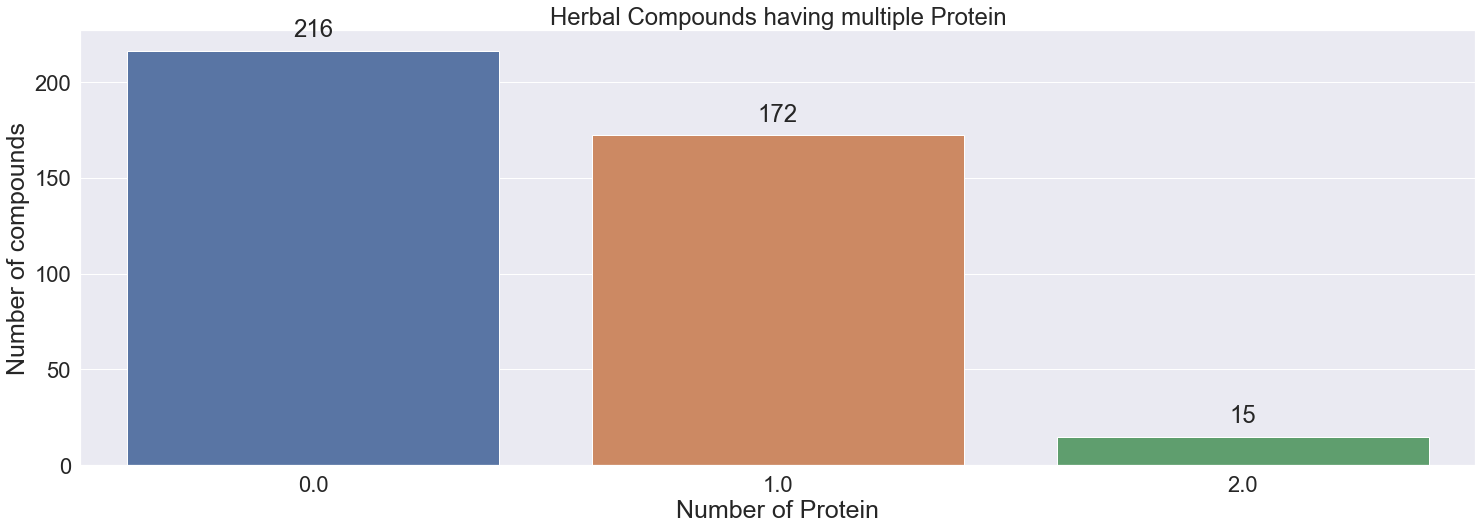

In [75]:

import seaborn as sns
import matplotlib.pyplot as plt
rowSums = hasil_predict.sum(axis=1)
multiLabel_counts = rowSums.value_counts()
# multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(25,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Herbal Compounds having multiple Protein")
plt.ylabel('Number of compounds', fontsize=25)
plt.xlabel('Number of Protein', fontsize=25)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

,Unnamed: 0,Senyawa,List Protein,Probability,Total
0,0,Tetrahydroxyflavone,['PRKCA'],[0.9765869],1.0
1,290,Cinnamaldehyde,['EGFR'],[0.80158496],1.0
2,291,Cinnamyl acetate,['EGFR'],[0.7742572],1.0
3,292,Cinnamyl alcohol,['EGFR'],[0.530358],1.0
4,293,Cis calamenene,['CSNK2A1'],[0.97914267],1.0
...,...,...,...,...,...
182,340,Goyaglycoside a,"['CSNK2A1', 'PRKCA']","[0.99323684, 0.82517236]",2.0
183,346,Diosgenin,"['CSNK2A1', 'PRKCA']","[0.9992392, 0.67388093]",2.0
184,162,Astragalin,"['PRKCA', 'EGFR']","[0.67801267, 0.7163887]",2.0
185,84,Naringin,"['PRKCA', 'EGFR']","[0.99882466, 0.5928809]",2.0


In [36]:
multiLabel_countsindex2 = [0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0, 10.0]
multiLabel_countsvalues2 = [136,  90,  50,  13,   6,   3,   1,   5,   1]
multiLabel_counts

0.0     136
1.0      90
2.0      50
3.0      13
4.0       6
7.0       5
5.0       3
10.0      1
6.0       1
dtype: int64

In [88]:
kelasdata[['MAPK14','CSNK2A1','PRKCA','AR','TF','EGFR']].sum()
# kelasdata.sum(axis=0).sort_values()
# kelasdata.sum()[kelasdata.sum()==1]

MAPK14     2755.0
CSNK2A1     225.0
PRKCA      1279.0
AR         1272.0
TF           35.0
EGFR       3098.0
dtype: float64

## Hasil Prediksi Daylight

D:\Anaconda3\envs\py37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


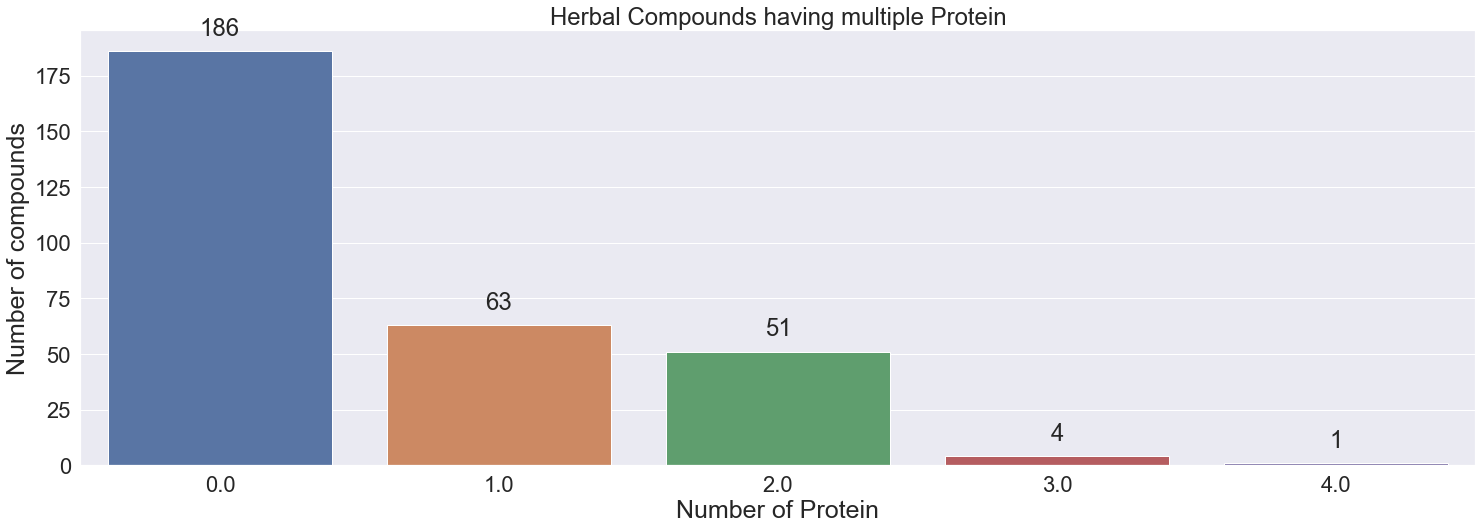

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
rowSums = hasil_predict.iloc[:,0:473].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
# multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(25,8))
ax = sns.barplot(multiLabel_counts.index, multiLabel_counts.values)
plt.title("Herbal Compounds having multiple Protein")
plt.ylabel('Number of compounds', fontsize=25)
plt.xlabel('Number of Protein', fontsize=25)
#adding the text labels
rects = ax.patches
labels = multiLabel_counts.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [26]:
hasil_predict2 = hasil_predict.iloc[:,0:473]
hasil_predict2.sum()[hasil_predict2.sum()>0].sort_values(ascending=False)

NFKB1       45.0
RELA        44.0
PRKCA       14.0
ELANE       14.0
TNFRSF1A    11.0
TOP1         9.0
ALOX5        8.0
IDE          6.0
AR           6.0
EIF3F        4.0
LGALS3       3.0
ADRB2        2.0
SELP         2.0
LGALS1       2.0
PLOD2        1.0
PLOD3        1.0
EGFR         1.0
TTR          1.0
P4HA1        1.0
PLOD1        1.0
NT5E         1.0
PTGS1        1.0
RAC1         1.0
CSNK2B       1.0
TK2          1.0
dtype: float32

In [4]:
kelasdata[['NFKB1', 'RELA', 'ELANE', 'TNFRSF1A', 'TOP1', 'ALOX5', 'IDE', 'AR', 'EIF3F', 'LGALS3','ADRB2',
          'SELP', 'LGALS1', 'PLOD2', 'PLOD3', 'EGFR', 'TTR', 'P4HA1', 'PLOD1', 'NT5E']].sum()

NFKB1        112.0
RELA          37.0
ELANE       1395.0
TNFRSF1A     117.0
TOP1         473.0
ALOX5       1190.0
IDE            5.0
AR          1272.0
EIF3F          1.0
LGALS3       151.0
ADRB2         84.0
SELP         241.0
LGALS1        77.0
PLOD2          3.0
PLOD3          4.0
EGFR        3098.0
TTR          108.0
P4HA1          6.0
PLOD1          5.0
NT5E           2.0
dtype: float64

In [28]:
prot_hasil_daylight = genecards_prot.loc[genecards_prot['Gene Symbol'].isin(hasil_predict2.sum()[hasil_predict2.sum()>0].sort_values(ascending=False).index.values)]
hasilpredictdf = pd.DataFrame(hasil_predict2.sum()[hasil_predict2.sum()>0].sort_values(ascending=False).values)
hasilpredictdf['Gene Symbol'] = hasil_predict2.sum()[hasil_predict2.sum()>0].sort_values(ascending=False).index.values
hasilpredictdf2 = pd.merge(prot_hasil_daylight,hasilpredictdf, on= 'Gene Symbol')
hasilpredictdf2.to_csv('prot_hasil_daylight.csv',index=False)
# hasilpredictdf2

## Hasil Prediksi CIRCULAR

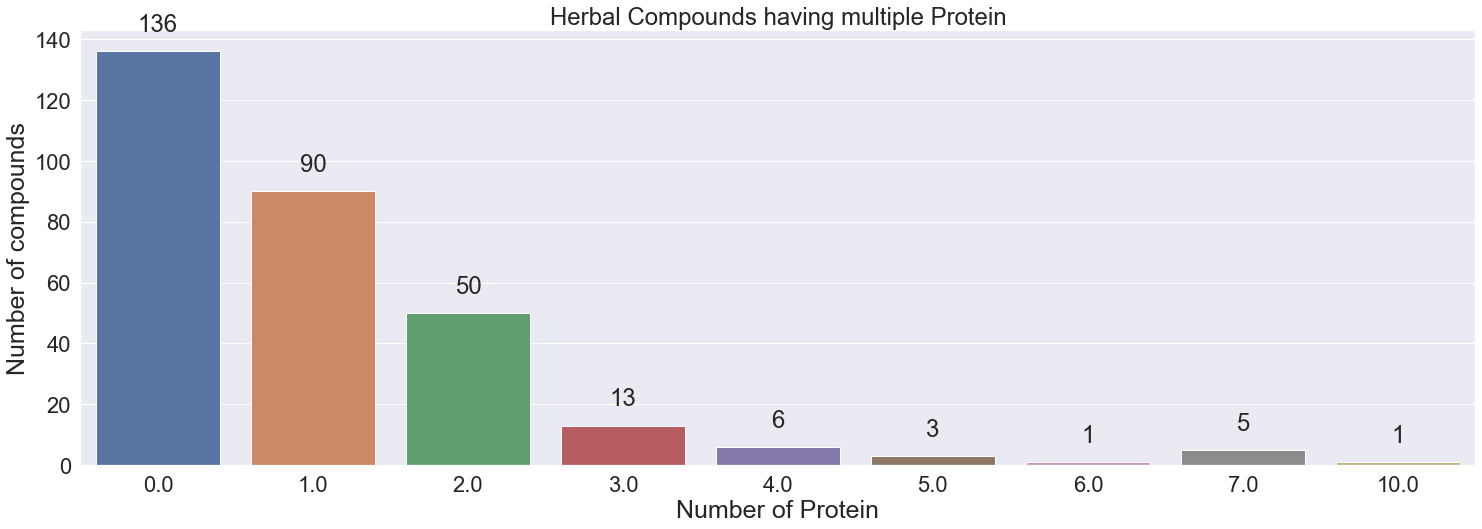

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt
rowSums = hasil_predict.iloc[:,0:473].sum(axis=1)
multiLabel_counts = rowSums.value_counts()
# multiLabel_counts = multiLabel_counts.iloc[1:]
sns.set(font_scale = 2)
plt.figure(figsize=(25,8))
ax = sns.barplot(x = multiLabel_countsindex2, y = multiLabel_countsvalues2)
plt.title("Herbal Compounds having multiple Protein")
plt.ylabel('Number of compounds', fontsize=25)
plt.xlabel('Number of Protein', fontsize=25)
#adding the text labels
rects = ax.patches
labels = multiLabel_countsvalues2
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')
plt.show()

In [136]:
hasil_predict.sum()[hasil_predict.sum()>0].sort_values(ascending=False)[:20]

NFKB1     44.0
RELA      40.0
PTGS1     21.0
PPARA     18.0
F3        14.0
ITGAL     14.0
ACHE      11.0
POLA1     10.0
FADS2     10.0
TOP1      10.0
ALOX5     10.0
PPT1       9.0
PRKCA      9.0
TLR4       9.0
LGALS3     7.0
AHR        5.0
FURIN      5.0
PVR        5.0
EIF3F      5.0
ELANE      4.0
dtype: float32

In [135]:
kelasdata[['NFKB1', 'RELA', 'PTGS1', 'PPARA', 'F3', 'ITGAL', 'ACHE', 'POLA1',
       'FADS2', 'TOP1', 'ALOX5', 'PPT1', 'PRKCA', 'TLR4', 'LGALS3', 'AHR',
       'FURIN', 'PVR', 'EIF3F', 'ELANE']].sum()
# hasil_predict.sum()[hasil_predict.sum()>0].index.values

NFKB1      112.0
RELA        37.0
PTGS1     2323.0
PPARA     1796.0
F3         181.0
ITGAL      257.0
ACHE      2340.0
POLA1      111.0
FADS2        3.0
TOP1       473.0
ALOX5     1190.0
PPT1         2.0
PRKCA     1279.0
TLR4         9.0
LGALS3     151.0
AHR         35.0
FURIN        1.0
PVR          2.0
EIF3F        1.0
ELANE     1395.0
dtype: float64

In [23]:
genecards_prot = pd.read_csv('D:\Thesis\Data\GeneCards Protein Only (Supplementary 2).csv')

In [150]:
prot_hasil_circular = genecards_prot.loc[genecards_prot['Gene Symbol'].isin(hasil_predict.sum()[hasil_predict.sum()>0].sort_values(ascending=False)[:20].index.values)]
hasilpredictdf = pd.DataFrame(hasil_predict.sum()[hasil_predict.sum()>0].sort_values(ascending=False)[:20].values)
hasilpredictdf['Gene Symbol'] = hasil_predict.sum()[hasil_predict.sum()>0].sort_values(ascending=False)[:20].index.values
hasilpredictdf2 = pd.merge(prot_hasil_circular,hasilpredictdf, on= 'Gene Symbol')
hasilpredictdf2.to_csv('prot_hasil_circular2.csv',index=False)

In [142]:
prot_hasil_circular

,No,Gene Symbol,Description,Category,Gifts,GC Id,Relevance score,GeneCards Link,Accession,freq
7,7,TLR4,Toll Like Receptor 4,Protein Coding,51,GC09P117704,11.928967,https://www.genecards.org/cgi-bin/carddisp.pl?...,O00206,44.0
14,14,F3,"Coagulation Factor III, Tissue Factor",Protein Coding,45,GC01M094530,10.370682,https://www.genecards.org/cgi-bin/carddisp.pl?...,P13726,40.0
43,44,FURIN,"Furin, Paired Basic Amino Acid Cleaving Enzyme",Protein Coding,47,GC15P090868,4.519403,https://www.genecards.org/cgi-bin/carddisp.pl?...,P09958,21.0
123,144,LGALS3,Galectin 3,Protein Coding,45,GC14P055124,1.963179,https://www.genecards.org/cgi-bin/carddisp.pl?...,P17931,18.0
125,146,AHR,Aryl Hydrocarbon Receptor,Protein Coding,49,GC07P016916,1.912567,https://www.genecards.org/cgi-bin/carddisp.pl?...,P35869,14.0
231,273,ELANE,"Elastase, Neutrophil Expressed",Protein Coding,47,GC19P000855,1.265914,https://www.genecards.org/cgi-bin/carddisp.pl?...,P08246,14.0
265,307,NFKB1,Nuclear Factor Kappa B Subunit 1,Protein Coding,52,GC04P102501,1.003278,https://www.genecards.org/cgi-bin/carddisp.pl?...,P19838,11.0
268,310,PRKCA,Protein Kinase C Alpha,Protein Coding,52,GC17P066302,1.003278,https://www.genecards.org/cgi-bin/carddisp.pl?...,P17252,10.0
279,321,RELA,"RELA Proto-Oncogene, NF-KB Subunit",Protein Coding,51,GC11M065653,1.003278,https://www.genecards.org/cgi-bin/carddisp.pl?...,Q04206,10.0
455,498,PPT1,Palmitoyl-Protein Thioesterase 1,Protein Coding,46,GC01M040072,0.965650,https://www.genecards.org/cgi-bin/carddisp.pl?...,P50897,10.0
